<a href="https://colab.research.google.com/github/Athonlive/NeoleagueArena/blob/main/Reinforcement_Learning_Robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

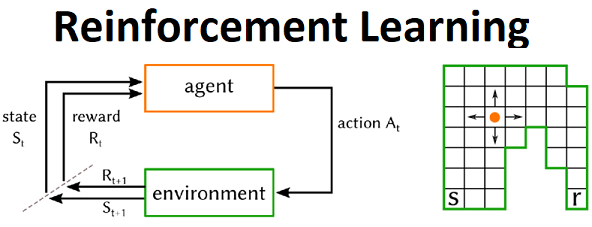

# Generate Model

**Step 1. Load dataset**

In [ ]:
import pandas as pd

dataset = pd.read_csv("/content/Data.csv",sep=";")

dataset.head()

,Simulation,StateR,StateC,TargetR,TargetC,Action,Reward
0,S1,3,9,8,5,UP,-1
1,S1,2,9,8,5,UP,-1
2,S1,1,9,8,5,UP,5
3,S1,10,9,8,5,RIGHT,-1
4,S1,10,10,8,5,UP,1


**Step 2. Drop Id and split Dataset**

In [ ]:
#Drop Id Column
dataset.drop('Simulation', axis = 1, inplace=True)

#Split X and Y
X = dataset.drop('Reward',axis=1)
Y = dataset['Reward']

print("\nX:\n")
print(X[:5])
print("\nY:\n")
print(Y[:5])


X:

   StateR  StateC  TargetR  TargetC Action
0       3       9        8        5     UP
1       2       9        8        5     UP
2       1       9        8        5     UP
3      10       9        8        5  RIGHT
4      10      10        8        5     UP

Y:

0   -1
1   -1
2    5
3   -1
4    1
Name: Reward, dtype: int64


**Step 3. Onehot encoding**

In [ ]:
#One hot encoding for Action column
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(X[['Action']]).toarray())
X = X.join(enc_df)
X = X.drop(['Action'],axis=1)

X.head()

,StateR,StateC,TargetR,TargetC,0,1,2,3
0,3,9,8,5,0.0,0.0,0.0,1.0
1,2,9,8,5,0.0,0.0,0.0,1.0
2,1,9,8,5,0.0,0.0,0.0,1.0
3,10,9,8,5,0.0,0.0,1.0,0.0
4,10,10,8,5,0.0,0.0,0.0,1.0


**Step 4. Train a MLPRegressor model**

In [ ]:
#Regresion Neural Network Model
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes = (100, 75, 50, 25), activation = 'relu', solver = 'sgd', learning_rate = 'adaptive', max_iter =500)
regressor.fit(X.values, Y.values)
print(regressor.loss_)

0.004332995957232389


**Step 5. Save trained model**

In [ ]:
#Save Model
import pickle
save_nn = open("Agent_NxN_TrainedModel", "wb")
pickle.dump(regressor, save_nn)
save_nn.close()

# Use Model

**Step 1. Load and use model.**

In [ ]:
#UP: 0 0 0 1
#DOWN: 1 0 0 0
#LEFT: 0 1 0 0
#RIGHT: 0 0 1 0

import numpy as np

def simulate(Id, CurrentR, CurrentC, TargetR, TargetC, MaxR, MaxC):
  regressor_file = open("Agent_NxN_TrainedModel", "rb")
  regressor = pickle.load(regressor_file)
  regressor_file.close()

  while CurrentR != TargetR or CurrentC != TargetC:

    UP_NN = np.array([CurrentR,CurrentC,TargetR,TargetC,0,0,0,1]).reshape(1,-1)
    DOWN_NN = np.array([CurrentR,CurrentC,TargetR,TargetC,1,0,0,0]).reshape(1,-1)
    LEFT_NN = np.array([CurrentR,CurrentC,TargetR,TargetC,0,1,0,0]).reshape(1,-1)
    RIGHT_NN = np.array([CurrentR,CurrentC,TargetR,TargetC,0,0,1,0]).reshape(1,-1)

    pred_rew = regressor.predict(UP_NN)
    Move = "UP"
    tmp = regressor.predict(DOWN_NN)
    if tmp > pred_rew:
      pred_rew = tmp
      Move = "DOWN"
    tmp = regressor.predict(LEFT_NN)
    if tmp > pred_rew:
      pred_rew = tmp
      Move = "LEFT"
    tmp = regressor.predict(RIGHT_NN)
    if tmp > pred_rew:
      pred_rew = tmp
      Move = "RIGHT"

    print(Id + ";" + str(CurrentR) + ";" + str(CurrentC) + ";" + str(TargetR) + ";" + str(TargetC) + ";" + Move + ";" + str(pred_rew[0]))

    if Move == "UP":
      CurrentR = CurrentR - 1
      if CurrentR < 1:
        CurrentR = MaxR
    elif Move == "DOWN":
      CurrentR = CurrentR + 1
      if CurrentR > MaxR:
        CurrentR = 1
    elif Move == "RIGHT":
      CurrentC = CurrentC + 1
      if CurrentC > MaxC:
        CurrentC = 1
    else:
      CurrentC = CurrentC - 1
      if CurrentC < 1:
        CurrentC = MaxC

  print(Id + ";" + str(TargetR) + ";" + str(TargetC) + ";" + str(TargetR) + ";" + str(TargetC) + ";" + "END" + ";" + str(1000))

**Step 2. Generate N simulations with the model.**

In [ ]:
def test():
  for i in range(5):
    MaxR = 10
    MaxC = 10

    CurrentR = np.random.randint(low=1, high=MaxR, size=1)[0]
    CurrentC = np.random.randint(low=1, high=MaxC, size=1)[0]
    TargetR = np.random.randint(low=1, high=MaxR, size=1)[0]
    TargetC = np.random.randint(low=1, high=MaxC, size=1)[0]

    print("S" + str(i) + ";" + str(CurrentR) + ";" + str(CurrentC)+ ";" + str(TargetR) + ";" + str(TargetC) + ";" + "NONE" + ";" + "-999")

    simulate("S" + str(i), CurrentR, CurrentC, TargetR, TargetC, MaxR, MaxC)

**Step 3. Run simulations.**

In [ ]:
test()

S0;6;7;5;1;NONE;-999
S0;6;7;5;1;LEFT;0.9570040401902365
S0;6;6;5;1;LEFT;0.9821513902116931
S0;6;5;5;1;UP;1.0045268087415806
S0;5;5;5;1;LEFT;1.0905847314764432
S0;5;4;5;1;LEFT;1.1613032839551165
S0;5;3;5;1;LEFT;1.2348824384187274
S0;5;2;5;1;LEFT;1.0051679486404166
S0;5;1;5;1;END;1000
S1;1;3;8;8;NONE;-999
S1;1;3;8;8;UP;4.955780088653439
S1;10;3;8;8;RIGHT;1.0474603327706267
S1;10;4;8;8;RIGHT;1.0721371857930566
S1;10;5;8;8;RIGHT;1.1083874141929444
S1;10;6;8;8;RIGHT;1.1132986235491882
S1;10;7;8;8;RIGHT;1.124353311223547
S1;10;8;8;8;UP;0.9489984797382806
S1;9;8;8;8;UP;0.9269823451674112
S1;8;8;8;8;END;1000
S2;1;2;8;2;NONE;-999
S2;1;2;8;2;UP;4.876345092658932
S2;10;2;8;2;UP;1.0733419368793506
S2;9;2;8;2;UP;1.007704969236444
S2;8;2;8;2;END;1000
S3;1;8;6;3;NONE;-999
S3;1;8;6;3;UP;1.1562100294468305
S3;10;8;6;3;UP;1.097768291245396
S3;9;8;6;3;UP;1.1006027159242504
S3;8;8;6;3;UP;1.082493868356507
S3;7;8;6;3;UP;0.9677902150027319
S3;6;8;6;3;LEFT;0.9291935636828813
S3;6;7;6;3;LEFT;1.098659775912361